# Pipelined Model - Random Oversampler - Random Forest Classifier

In [1]:
import datetime, warnings, scipy
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-whitegrid')
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
from scipy import stats
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

import os
# Storing
import joblib

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor


# Performance Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pointbiserialr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

# Imbalanced Dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


pd.options.display.float_format = '{:.0f}'.format

In [2]:
from pathlib import Path
data_path=Path('http://localhost:8888/tree/TFM')
dataset=pd.read_csv('flights.csv',low_memory=False)
dataset.head()
dataset.shape

(5819079, 31)

In [3]:
# Missing Values set to 0
dataset['WEATHER_DELAY'] = dataset['WEATHER_DELAY'].fillna(0)
dataset['LATE_AIRCRAFT_DELAY'] = dataset['LATE_AIRCRAFT_DELAY'].fillna(0)
dataset['AIRLINE_DELAY'] = dataset['AIRLINE_DELAY'].fillna(0)
dataset['SECURITY_DELAY'] = dataset['SECURITY_DELAY'].fillna(0)
dataset['AIR_SYSTEM_DELAY'] = dataset['AIR_SYSTEM_DELAY'].fillna(0)

In [4]:
# Drop Columns
dataset.drop(['YEAR','FLIGHT_NUMBER','TAIL_NUMBER','DIVERTED','CANCELLED','CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY','SCHEDULED_TIME','DISTANCE'],
                 axis = 1, inplace = True)

In [5]:
dataset = dataset.dropna()
dataset.shape
dataset.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,ANC,SEA,5,2354,-11,21,15,194,169,404,4,430,408,-22
1,1,1,4,AA,LAX,PBI,10,2,-8,12,14,279,263,737,4,750,741,-9
2,1,1,4,US,SFO,CLT,20,18,-2,16,34,293,266,800,11,806,811,5
3,1,1,4,AA,LAX,MIA,20,15,-5,15,30,281,258,748,8,805,756,-9
4,1,1,4,AS,SEA,ANC,25,24,-1,11,35,215,199,254,5,320,259,-21


In [6]:
# Date Transformation
import calendar

# 1 = Weekday, 0 = Weekend
Day_Week_Type = []
for value in dataset['DAY_OF_WEEK']:
    if value in (0,1,2,3,4):
        Day_Week_Type.append(1) # Weekday
    else:
        Day_Week_Type.append(0) # Weekend
dataset['WEEKDAY_TYPE'] = Day_Week_Type
dataset.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEEKDAY_TYPE
0,1,1,4,AS,ANC,SEA,5,2354,-11,21,15,194,169,404,4,430,408,-22,1
1,1,1,4,AA,LAX,PBI,10,2,-8,12,14,279,263,737,4,750,741,-9,1
2,1,1,4,US,SFO,CLT,20,18,-2,16,34,293,266,800,11,806,811,5,1
3,1,1,4,AA,LAX,MIA,20,15,-5,15,30,281,258,748,8,805,756,-9,1
4,1,1,4,AS,SEA,ANC,25,24,-1,11,35,215,199,254,5,320,259,-21,1


In [7]:
from sklearn import preprocessing
Label_Encoder = preprocessing.LabelEncoder()
dataset['AIRLINE'] = Label_Encoder.fit_transform(dataset['AIRLINE'])
dataset['ORIGIN_AIRPORT'] = Label_Encoder.fit_transform(dataset['ORIGIN_AIRPORT'])
dataset['DESTINATION_AIRPORT'] = Label_Encoder.fit_transform(dataset['DESTINATION_AIRPORT'])
dataset.dtypes

MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                  int32
ORIGIN_AIRPORT           int32
DESTINATION_AIRPORT      int32
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
ELAPSED_TIME           float64
AIR_TIME               float64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
WEEKDAY_TYPE             int64
dtype: object

## Target Attribute: Flight Status
FLIGHT_STATUS determines whether the flight arrives on time (ARRIVAL_DELAY <= 15min) or it is delayed (ARRIVAL_DELAY > 15min). FLIGHT_STATUS value is 0 if flights arrive early or on time and 1 for flights that are delayed.

In [8]:
Status = []

for Value in dataset['ARRIVAL_DELAY']:
    if Value <= 15:
        Status.append(0)
    else:
        Status.append(1)
dataset['FLIGHT_STATUS'] = Status
dataset.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEEKDAY_TYPE,FLIGHT_STATUS
0,1,1,4,1,323,584,5,2354,-11,21,15,194,169,404,4,430,408,-22,1,0
1,1,1,4,0,482,542,10,2,-8,12,14,279,263,737,4,750,741,-9,1,0
2,1,1,4,11,584,373,20,18,-2,16,34,293,266,800,11,806,811,5,1,0
3,1,1,4,0,482,510,20,15,-5,15,30,281,258,748,8,805,756,-9,1,0
4,1,1,4,1,583,324,25,24,-1,11,35,215,199,254,5,320,259,-21,1,0


## Dataset Splitting for Training and Testing

In [9]:
Labels = dataset[["FLIGHT_STATUS", "ARRIVAL_DELAY"]]
Features = dataset.drop(columns = ['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'FLIGHT_STATUS', 'ARRIVAL_DELAY'])
print(f"\nDataset Shape: {dataset.shape}")
dataset.head()


Dataset Shape: (5714008, 20)


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEEKDAY_TYPE,FLIGHT_STATUS
0,1,1,4,1,323,584,5,2354,-11,21,15,194,169,404,4,430,408,-22,1,0
1,1,1,4,0,482,542,10,2,-8,12,14,279,263,737,4,750,741,-9,1,0
2,1,1,4,11,584,373,20,18,-2,16,34,293,266,800,11,806,811,5,1,0
3,1,1,4,0,482,510,20,15,-5,15,30,281,258,748,8,805,756,-9,1,0
4,1,1,4,1,583,324,25,24,-1,11,35,215,199,254,5,320,259,-21,1,0


In [10]:
Features_Train, Features_Test, Labels_Train, Labels_Test = train_test_split(Features, Labels, test_size=0.20, train_size=0.8, random_state=42)
del Features
del Labels

## Filtering for Classification Training and Testing

In [11]:
# Filtering Data for Classification Training and Testing
Classification_Features_Train, Classification_Features_Test = Features_Train, Features_Test
Classification_Labels_Train, Classification_Labels_Test = Labels_Train["FLIGHT_STATUS"], Labels_Test["FLIGHT_STATUS"]

## Resolving Imbalance for Classification

### Training Data previous to Handling Imbalance

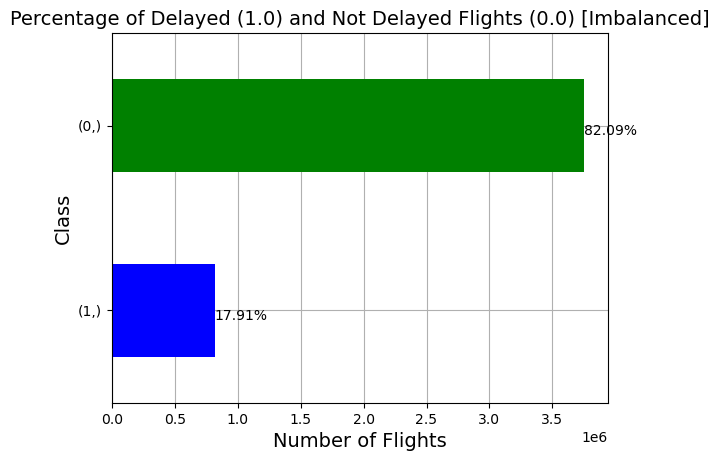

0    4690510
1    1023498
Name: FLIGHT_STATUS, dtype: int64


In [12]:
# Percentage of flights that are Delayed (1.0) and Not Delayed (0.0)
ax = pd.DataFrame(Classification_Labels_Train).value_counts().sort_values().plot(kind="barh", color=["b", "g"])
ax.set_axisbelow(True)
ax.grid()
Totals= []
for i in ax.patches:
    Totals.append(i.get_width())
Total = sum(Totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/Total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Percentage of Delayed (1.0) and Not Delayed Flights (0.0) [Imbalanced]", fontsize=14)
plt.xlabel("Number of Flights", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(dataset["FLIGHT_STATUS"].value_counts())
fig = ax.get_figure()

In [13]:
dataset = dataset.dropna()
dataset.shape
dataset.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEEKDAY_TYPE,FLIGHT_STATUS
0,1,1,4,1,323,584,5,2354,-11,21,15,194,169,404,4,430,408,-22,1,0
1,1,1,4,0,482,542,10,2,-8,12,14,279,263,737,4,750,741,-9,1,0
2,1,1,4,11,584,373,20,18,-2,16,34,293,266,800,11,806,811,5,1,0
3,1,1,4,0,482,510,20,15,-5,15,30,281,258,748,8,805,756,-9,1,0
4,1,1,4,1,583,324,25,24,-1,11,35,215,199,254,5,320,259,-21,1,0


## Sampled Data: Random Oversampler

In [14]:
ROS = RandomOverSampler(random_state=42)
Classification_Features_Train, Classification_Labels_Train = ROS.fit_resample(Classification_Features_Train, Classification_Labels_Train)

### Balanced Training Data - Random Undersampling

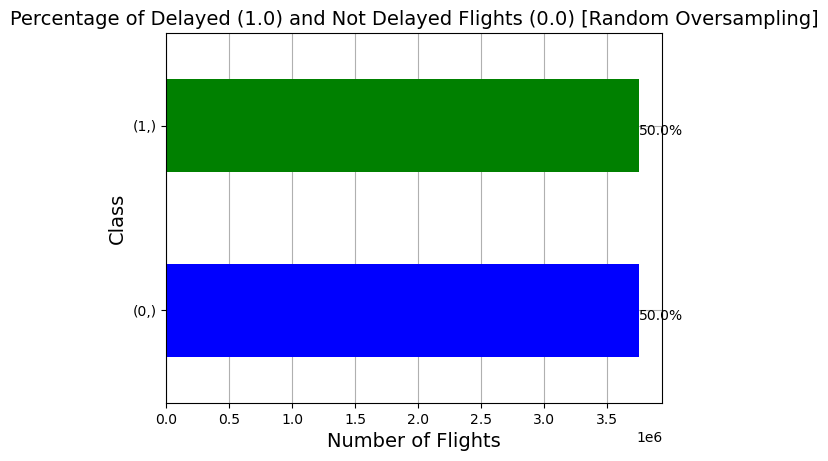

FLIGHT_STATUS
0                3752502
1                3752502
dtype: int64


In [15]:
# Percentage of flights that are Delayed (1.0) and Not Delayed (0.0): Sampled Data - Random Oversampler
ax = pd.DataFrame(Classification_Labels_Train).value_counts().sort_values().plot(kind="barh", color=["b", "g"])
ax.set_axisbelow(True)
ax.grid()
Totals= []
for i in ax.patches:
    Totals.append(i.get_width())
Total = sum(Totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/Total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Percentage of Delayed (1.0) and Not Delayed Flights (0.0) [Random Oversampling]", fontsize=14)
plt.xlabel("Number of Flights", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(Classification_Labels_Train).value_counts())
fig = ax.get_figure()

## Random Forest Classifier - Random Oversampler

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    938008
           1       0.89      0.85      0.87    204794

    accuracy                           0.96   1142802
   macro avg       0.93      0.91      0.92   1142802
weighted avg       0.95      0.96      0.95   1142802

Balanced Accuracy (Test Set): 0.915
F1-Score (Test Set): 0.871



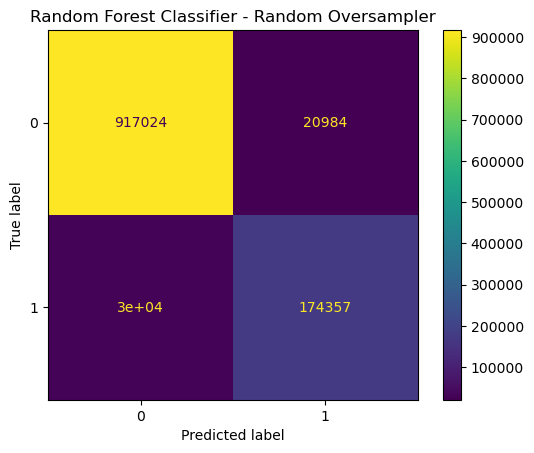

In [16]:
Model = RandomForestClassifier(n_jobs=-1)
Model.fit(Classification_Features_Train, Classification_Labels_Train)
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("Random Forest Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

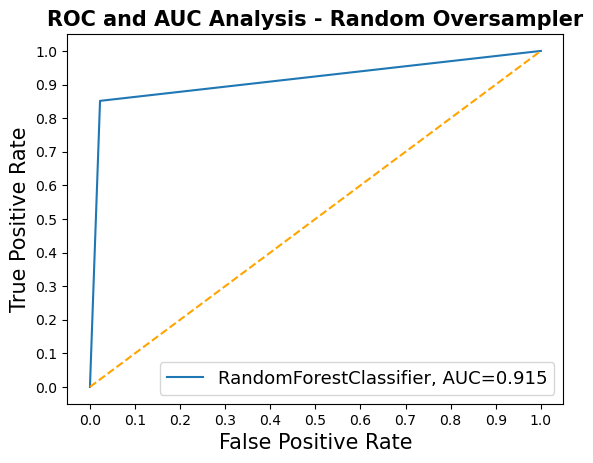

In [17]:
FPR, TPR, _ = roc_curve(Classification_Labels_Test,  Model_Pred)
AUC = roc_auc_score(Classification_Labels_Test, Model_Pred)
plt.plot(FPR, TPR, label="{}, AUC={:.3f}".format("RandomForestClassifier", AUC))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title("ROC and AUC Analysis - Random Oversampler", fontweight="bold", fontsize=15)
plt.legend(prop={"size":13}, loc="lower right")

plt.show()

## XGBoost Regressor

### Regression Data Filtering (taking into account Classifier Predictions)

In [18]:
# Delayed Flights predicted by the Classifier
Delayed_Flights_Features = Features_Test
# Column to Filter
Delayed_Flights_Features["Predicted_FLIGHT_STATUS"] = Model_Pred
Delayed_Flights_Features = Delayed_Flights_Features.loc[:][Delayed_Flights_Features["Predicted_FLIGHT_STATUS"] == 1.0]
Delayed_Flights_Features = Delayed_Flights_Features.drop(["Predicted_FLIGHT_STATUS"], axis=1)

In [19]:
Delayed_Flights_Labels = pd.DataFrame(Labels_Test["ARRIVAL_DELAY"])
Delayed_Flights_Labels["Predicted_FLIGHT_STATUS"] = Model_Pred
Delayed_Flights_Labels = Delayed_Flights_Labels.loc[:][Delayed_Flights_Labels["Predicted_FLIGHT_STATUS"] == 1.0]
Delayed_Flights_Labels = Delayed_Flights_Labels.drop(["Predicted_FLIGHT_STATUS"], axis=1)
Delayed_Flights_Labels = np.asarray(Delayed_Flights_Labels["ARRIVAL_DELAY"])

In [20]:
Delayed_Flights_Features.shape, Delayed_Flights_Labels.shape

((195341, 16), (195341,))

### Dataset Splitting for Training and Testing

In [21]:
Regression_Features_Train, Regression_Features_Test, Regression_Labels_Train, Regression_Labels_Test = train_test_split(Delayed_Flights_Features, Delayed_Flights_Labels, test_size=0.20, train_size=0.8, random_state=42)

### XGBoost Regressor (Model Evaluation)

In [22]:
Performance_DF = pd.DataFrame(columns=["Regressors", "MSE", "RMSE", "MAE", "R2"])
def print_metrics(Labels_Test, Model_Pred, regressor_name, Performance_DF):
    
    MSE = mean_squared_error(Labels_Test, Model_Pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(Labels_Test, Model_Pred)
    r2 = r2_score(Labels_Test, Model_Pred)
    
    print(f"MSE      : {MSE}", end="\n\n")
    print(f"RMSE     : {RMSE}", end="\n\n")
    print(f"MAE      : {MAE}", end="\n\n")
    print(f"R2 Score : {r2}", end="\n\n")
    
    Performance_DF = Performance_DF.append({"Regressors": regressor_name,
                                        "MSE": MSE, 
                                        "RMSE": RMSE,
                                        "MAE": MAE,
                                        "R2": r2}, ignore_index=True)
    return Performance_DF

In [23]:
Model = XGBRegressor()
Model.fit(Regression_Features_Train, Regression_Labels_Train)
FileName = 'XGBRegressor_Pipeline_RandomOversampler.joblib'
joblib.dump(Model, FileName)
Model = joblib.load('XGBRegressor_Pipeline_RandomOversampler.joblib')
Model_Pred = Model.predict(Regression_Features_Test)
Performance_DF = print_metrics(Regression_Labels_Test, Model_Pred, "XGBRegressor", Performance_DF)
del Model
del Model_Pred

MSE      : 91.07215537003164

RMSE     : 9.543173233785062

MAE      : 6.834741108341657

R2 Score : 0.9793287987452757



### Regression Analysis

In [24]:
# Dataset is splitted taking into account the Flight Arrival Delay in Minutes to determine the regressor performance variation.

Regression_Features_Test["ARRIVAL_DELAY"] = pd.DataFrame(Regression_Labels_Test)[0].values
print("Min: ", Regression_Features_Test["ARRIVAL_DELAY"].min())
print("Max: ", Regression_Features_Test["ARRIVAL_DELAY"].max())
Model = joblib.load('XGBRegressor_Pipeline_RandomOversampler.joblib')

Min:  -27.0
Max:  1381.0


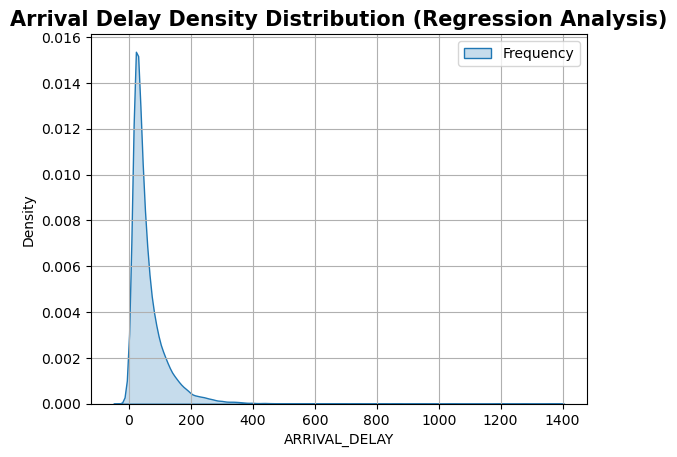

In [25]:
fig, ax = plt.subplots()
plt.grid()
ax = sns.kdeplot(Regression_Features_Test["ARRIVAL_DELAY"], shade=True, label='Frequency')
ax.legend(loc='upper right')
plt.title("Arrival Delay Density Distribution (Regression Analysis)", fontweight="bold", fontsize=15)
plt.show()

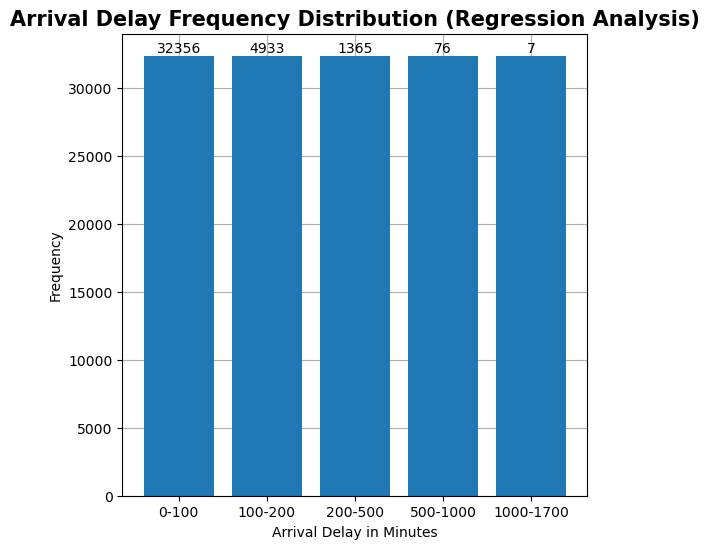

In [26]:
Ranges = [0, 100, 200, 500, 1000, 1700]
Result = Regression_Features_Test["ARRIVAL_DELAY"].groupby(pd.cut(Regression_Features_Test["ARRIVAL_DELAY"], Ranges)).count()
Data = {'0-100': Result[1], '100-200': Result[2], '200-500': Result[3], '500-1000': Result[4],'1000-1700': Result[5]}
Names = list(Data.keys())    
Values = list(Data.values())

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid()
ax.set_axisbelow(True)
ax.bar(Names, Values)
plt.title("Arrival Delay Frequency Distribution (Regression Analysis)", fontweight="bold", fontsize=15)
plt.xlabel("Arrival Delay in Minutes")
plt.ylabel("Frequency")

rects = ax.patches
labels = list(Result)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.show()

### Range 0 to 100 (Arrival Delay in Minutes)

In [27]:
df = Regression_Features_Test.loc[Regression_Features_Test["ARRIVAL_DELAY"].isin(list(range(0, 100)))]
print("Shape: ", df.shape, end="\n\n")

X_Test = df.drop(columns=["ARRIVAL_DELAY"])
y_Test = df["ARRIVAL_DELAY"].values

Model_Pred = Model.predict(X_Test)
Performance_DF = print_metrics(y_Test, Model_Pred, "XGBRegressor", Performance_DF)

Shape:  (32336, 17)

MSE      : 75.8467817942661

RMSE     : 8.709005786785658

MAE      : 6.405926764774505

R2 Score : 0.8576105914380665



### Range 100 to 200 (Arrival Delay in Minutes)

In [28]:
df = Regression_Features_Test.loc[Regression_Features_Test["ARRIVAL_DELAY"].isin(list(range(100, 200)))]
print("Shape: ", df.shape, end="\n\n")

X_Test = df.drop(columns=["ARRIVAL_DELAY"])
y_Test = df["ARRIVAL_DELAY"].values

Model_Pred = Model.predict(X_Test)
Performance_DF = print_metrics(y_Test, Model_Pred, "XGBRegressor", Performance_DF)

Shape:  (5013, 17)

MSE      : 143.25538320715336

RMSE     : 11.968934088178168

MAE      : 8.10153828393954

R2 Score : 0.8006928510343199



### Range 200 to 500 (Arrival Delay in Minutes)

In [29]:
df = Regression_Features_Test.loc[Regression_Features_Test["ARRIVAL_DELAY"].isin(list(range(200, 500)))]
print("Shape: ", df.shape, end="\n\n")

X_Test = df.drop(columns=["ARRIVAL_DELAY"])
y_Test = df["ARRIVAL_DELAY"].values

Model_Pred = Model.predict(X_Test)
Performance_DF = print_metrics(y_Test, Model_Pred, "XGBRegressor", Performance_DF)

Shape:  (1375, 17)

MSE      : 166.1612595316546

RMSE     : 12.890355291133545

MAE      : 9.10139600719105

R2 Score : 0.9638906019625645



### Range 500 to 1000 (Arrival Delay in Minutes)

In [30]:
df = Regression_Features_Test.loc[Regression_Features_Test["ARRIVAL_DELAY"].isin(list(range(500, 1000)))]
print("Shape: ", df.shape, end="\n\n")

X_Test = df.drop(columns=["ARRIVAL_DELAY"])
y_Test = df["ARRIVAL_DELAY"].values

Model_Pred = Model.predict(X_Test)
Performance_DF = print_metrics(y_Test, Model_Pred, "XGBRegressor", Performance_DF)

Shape:  (78, 17)

MSE      : 271.68788127248916

RMSE     : 16.48295729753885

MAE      : 12.93202365973057

R2 Score : 0.9845558680688357



### Range 1000 to 1700 (Arrival Delay in Minutes)

In [31]:
df = Regression_Features_Test.loc[Regression_Features_Test["ARRIVAL_DELAY"].isin(list(range(1000, 1700)))]
print("Shape: ", df.shape, end="\n\n")

X_Test = df.drop(columns=["ARRIVAL_DELAY"])
y_Test = df["ARRIVAL_DELAY"].values

Model_Pred = Model.predict(X_Test)
Performance_DF = print_metrics(y_Test, Model_Pred, "XGBRegressor", Performance_DF)

Shape:  (7, 17)

MSE      : 409.9997226473476

RMSE     : 20.24844988257984

MAE      : 18.203517368861608

R2 Score : 0.9741948420351793

